In [1]:
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

from spdm.data import File
from spdm.util.logger import logger
from spdm.view.plot_profiles import plot_profiles, sp_figure


In [ ]:
eqdsk = File("/home/salmon/workspace/SpDB/examples/data/g080307.63000",format="geqdsk").read().dump()

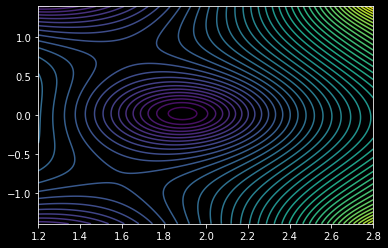

In [9]:
plt.contour(eqdsk["profiles_2d.grid.dim1"],eqdsk["profiles_2d.grid.dim2"],eqdsk["profiles_2d.psi"],levels=50)

In [5]:
eqdsk["profiles_2d.psi"].shape

(129, 129)

In [30]:
d=np.linspace(0,119,120)

In [31]:
d.reshape([10,12])

array([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.],
       [ 12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
         23.],
       [ 24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
         35.],
       [ 36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
         47.],
       [ 48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,
         59.],
       [ 60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,
         71.],
       [ 72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,
         83.],
       [ 84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,
         95.],
       [ 96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106.,
        107.],
       [108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118.,
        119.]])

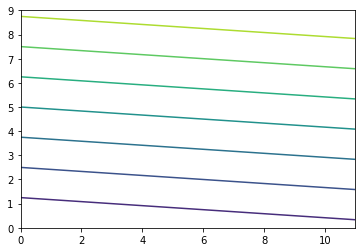

In [33]:
plt.contour(d.reshape([10,12]))